In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import reproject, Resampling
import matplotlib.patches as mpatches
import geopandas as gpd
from rasterio.mask import mask
import shapely.geometry
from itertools import combinations
import warnings
import json
from affine import Affine

warnings.filterwarnings("ignore")
import seaborn as sns
import pandas as pd
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as mtransforms
from scipy.ndimage import rotate




plt.rcParams.update(
    {
        "axes.titlesize": 24,  # Title font size
        "axes.labelpad": 10,  # Padding for the x and y labels
        "axes.labelcolor": "dimgray",
        "xtick.labelsize": 16,  # Font size for the x tick labels
        "ytick.labelsize": 16,  # Font size for the y tick labels
        "axes.labelsize": 20,  # Font size for the x and y axis labels
        "font.family": "serif",  # Set the font family to Arial
        "grid.linestyle": "--",  # Set the style of the gridlines
        "grid.linewidth": 0.5,  # Set the width of the gridlines
        "grid.color": "gray",  # Set the color of the gridlines
        "axes.grid": True,  # Enable the grid
        "axes.grid.which": "both",  # Apply the grid to both major and minor ticks
        # "xtick.direction": "in",  # Set the direction of the x tick marks
        # "ytick.direction": "in",  # Set the direction of the y tick marks
        # "xtick.major.size": 6,  # Set the length of the major x tick marks
        # "xtick.major.width": 2,  # Set the width of the major x tick marks
        # "ytick.major.size": 6,  # Set the length of the major y tick marks
        # "ytick.major.width": 2,  # Set the width of the major y tick marks
        "xtick.color": "gray",  # Color of x tick labels and tick lines
        "ytick.color": "gray",  # Color of y tick labels and tick lines
    }
)


In [2]:
def clip_raster(filepath, bbox_geojson):
    bbox_geom = gpd.GeoDataFrame.from_features(
        [{"type": "Feature", "properties": {}, "geometry": bbox_geojson}],
        crs="EPSG:4326",
    )
    with rasterio.open(filepath) as src:
        src_crs = src.crs if src.crs else "EPSG:4326"
        bbox_geom = bbox_geom.to_crs(crs=src_crs)
        intersection = bbox_geom.unary_union.intersection(
            shapely.geometry.box(*src.bounds)
        )
        if not intersection.is_empty:
            out_image, out_transform = mask(src, shapes=[intersection], crop=True)
            out_image[out_image < -1000] = np.nan
            out_meta = src.meta.copy()
            out_meta.update(
                {
                    "driver": "GTiff",
                    "height": out_image.shape[1],
                    "width": out_image.shape[2],
                    "transform": out_transform,
                    "nodata": np.nan,
                }
            )
            out_image = out_image + NAVD88toMSL
            out_image = preprocess_raster(out_image)
            return out_image, out_transform, out_meta
    return None, None, None


In [3]:
def align_raster(
    source_array,
    source_transform,
    source_meta,
    target_transform,
    target_crs,
    template_shape,
):
    aligned_array = np.empty(template_shape)
    reproject(
        source=source_array,
        destination=aligned_array,
        src_transform=source_transform,
        src_crs=source_meta["crs"],
        dst_transform=target_transform,
        dst_crs=target_crs,
        resampling=Resampling.nearest,
    )
    return aligned_array


In [4]:
def rotate_image(
    image, transform, meta, angle, shift_x=0, shift_y=0, adj_width=0, adj_height=0
):

    src_transform = transform
    rotate = Affine.rotation(angle)
    trans_x = Affine.translation(shift_x, 0)
    trans_y = Affine.translation(0, -shift_y)
    dst_transform = src_transform * rotate * trans_x * trans_y

    y, x = image.shape[1:]
    dst_height = int(y + adj_height)
    dst_width = int(x + adj_width)

    dst_image = np.empty(
        shape=(image.shape[0], dst_height, dst_width), dtype=image.dtype
    )

    meta.update(
        {
            "transform": dst_transform,
            "height": dst_height,
            "width": dst_width,
            "nodata": np.nan,
        }
    )

    reproject(
        source=image,
        destination=dst_image,
        src_transform=src_transform,
        dst_transform=dst_transform,
        src_crs=meta["crs"],
        dst_crs=meta["crs"],
        resampling=Resampling.nearest,
        src_nodata=meta.get("nodata"),
        dst_nodata=np.nan,
    )

    # Find the bounding box where data exists
    valid_data_positions = np.where(~np.isnan(dst_image))
    ymin, xmin = valid_data_positions[1].min(), valid_data_positions[2].min()
    ymax, xmax = valid_data_positions[1].max(), valid_data_positions[2].max()

    # Clip the image to the bounding box
    dst_image_clipped = dst_image[:, ymin : ymax + 1, xmin : xmax + 1]
    plt.imshow(dst_image_clipped[0], cmap="gray")
    plt.title("Rotated and Clipped Image")
    plt.show()

    # Update metadata for the clipped image
    new_height, new_width = dst_image_clipped.shape[1], dst_image_clipped.shape[2]
    new_transform = dst_transform * Affine.translation(xmin, ymin)
    meta.update(
        {
            "transform": new_transform,
            "height": new_height,
            "width": new_width,
        }
    )

    return dst_image_clipped, new_transform, meta


In [5]:
def preprocess_raster(array):
    array[(array < -10) | (array > 10)] = np.nan
    array[array < 0] = 0
    return array


In [6]:
def generate_accretion_erosion_map(difference):
    # Initialize an array with all values set to green ([0, 1, 0]) indicating 'no change'
    difference_color_mapped = np.full(
        (difference.shape[0], difference.shape[1], 3), [1, 1, 1], dtype=np.float64
    )

    # Set pixels where there is erosion (difference < 0) to red ([1, 0, 0])
    difference_color_mapped[difference < 0] = [1, 0, 0]

    # Set pixels where there is accretion (difference > 0) to blue ([0, 0, 1])
    difference_color_mapped[difference > 0] = [0, 0, 1]

    return difference_color_mapped


In [7]:
# def plot_raster(ax, array, name, vmin=0, vmax=2.5):
#     im_raster = ax.imshow(
#         array.squeeze(), cmap="terrain", vmin=vmin, vmax=vmax, aspect="auto"
#     )
#     plt.colorbar(im_raster, ax=ax, fraction=0.046, pad=0.04)
#     ax.set_title(name)


# def plot_contour(ax, array, name, levels=[0.0, 0.5, 1, 1.5, 2]):
#     contour = ax.contour(array.squeeze(), levels=levels, cmap="viridis", aspect="auto")
#     ax.clabel(contour, fmt="")
#     ax.set_title(f"Elevation Contours ({name})")
#     ax.invert_yaxis()

#     colors = [
#         contour.collections[j].get_edgecolor()[0]
#         for j in range(len(contour.collections))
#     ]
#     labels = [f"{level}" for level in contour.levels]
#     patches = [
#         plt.Line2D([0], [0], color=colors[j], linewidth=1, linestyle="-")
#         for j in range(len(colors))
#     ]
#     ax.legend(patches, labels, loc="lower right")


# def plot_difference_map(ax, difference, name):
#     im_diff = ax.imshow(difference, cmap="PiYG", vmin=-1, vmax=1, aspect="auto")

#     plt.colorbar(im_diff, ax=ax, fraction=0.046, pad=0.04, label="Elevation Change")
#     ax.set_title(f"DEM Difference ({name})")


# def plot_accretion_erosion_map(ax, difference_color_mapped, name):
#     ax.imshow(difference_color_mapped, aspect="auto")
#     ax.set_title(f"Accretion (Blue) vs Erosion (Red) - {name}")
#     blue_patch = mpatches.Patch(color="blue", label="Accretion")
#     red_patch = mpatches.Patch(color="red", label="Erosion")
#     ax.legend(handles=[blue_patch, red_patch], loc="upper right")


# def plot_results(rasters, differences, names):
#     fig, axs = plt.subplots(
#         3, 2, figsize=(16, 16), gridspec_kw={"hspace": 0.2, "wspace": 0.2}
#     )
#     axs = axs.ravel()

#     difference = differences[0]
#     difference_color_mapped = generate_accretion_erosion_map(difference)

#     for i, (array, name) in enumerate(zip(rasters, names)):
#         plot_raster(axs[i], array, name)

#     for i in range(2):
#         plot_contour(axs[2 + i], rasters[i], names[i])

#     plot_difference_map(axs[4], difference, f"{names[0]} - {names[1]}")
#     plot_accretion_erosion_map(
#         axs[5], difference_color_mapped, f"{names[0]} - {names[1]}"
#     )

#     # Labeling each subplot
#     labels = ["A)", "B)", "C)", "D)", "E)", "F)"]
#     for label, ax in zip(labels, axs):
#         trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
#         ax.text(
#             0.0,
#             1.0,
#             label,
#             transform=ax.transAxes + trans,
#             fontsize="medium",
#             verticalalignment="top",
#             fontfamily="serif",
#             bbox=dict(facecolor="0.7", edgecolor="none", pad=3.0),
#         )

#     for ax in axs:
#         ax.set_xticks([])
#         ax.set_yticks([])
#         ax.set_xticklabels([])
#         ax.set_yticklabels([])

#     plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
#     plt.tight_layout()
#     # plt.savefig(
#     #     f"Results/Raster Differences/ ({names[0]} - {names[1]}).png",
#     #     format="png",
#     #     dpi=1200,
#     # )
#     plt.show()


In [8]:

def plot_raster(ax, array, name, vmin=0, vmax=2.5):
    im_raster = ax.imshow(
        array.squeeze(), cmap="terrain", vmin=vmin, vmax=vmax, aspect="auto"
    )
    plt.colorbar(im_raster, ax=ax, fraction=0.046, pad=0.04, label="Elevation(m)")
    ax.set_title(f"DEM ({name})")

def plot_contour(ax, array, name, levels=[0.0, 0.5, 1, 1.5, 2]):
    colors = ['blue', 'green', 'yellow', 'peru', 'brown']
    contour = ax.contour(array.squeeze(), levels=levels, colors=colors, aspect="auto")
    ax.clabel(contour, fmt="")
    ax.set_title(f"Elevation Contours ({name})")
    ax.invert_yaxis()

    labels = [f"{level} m" for level in contour.levels]
    patches = [
        plt.Line2D([0], [0], color=colors[j], linewidth=2, linestyle="-")
        for j in range(len(colors))
    ]
    ax.legend(patches, labels, loc="lower right")

def plot_difference_map(ax, difference, name):
    im_diff = ax.imshow(difference, cmap="PiYG", vmin=-1, vmax=1, aspect="auto")

    plt.colorbar(im_diff, ax=ax, fraction=0.046, pad=0.04, label="Elevation Change (m)")
    ax.set_title(f"DEM Difference \n({name})")

def plot_accretion_erosion_map(ax, difference_color_mapped, name):
    ax.imshow(difference_color_mapped, aspect="auto")
    ax.set_title(f"Accretion (Blue) vs Erosion (Red)\n ({name})")
    blue_patch = mpatches.Patch(color="blue", label="Accretion")
    red_patch = mpatches.Patch(color="red", label="Erosion")
    ax.legend(handles=[blue_patch, red_patch], loc="upper right")

def plot_results(rasters, differences, names):
    fig, axs = plt.subplots( 3, 2, figsize=(16, 16), gridspec_kw={"hspace": 0.2, "wspace": 0.2}
    )
    axs = axs.ravel()

    difference = differences[0]
    difference_color_mapped = generate_accretion_erosion_map(difference)

    for i, (array, name) in enumerate(zip(rasters, names)):
        plot_raster(axs[i], array, name)

    for i in range(2):
        plot_contour(axs[2 + i], rasters[i], names[i])

    plot_difference_map(axs[4], difference, f"{names[0]} - {names[1]}")
    plot_accretion_erosion_map(
        axs[5], difference_color_mapped, f"{names[0]} - {names[1]}"
    )

    labels = ["A)", "B)", "C)", "D)", "E)", "F)"]
    for label, ax in zip(labels, axs):
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
        ax.text(
            0.0,
            1.0,
            label,
            transform=ax.transAxes + trans,
            fontsize="20",
            verticalalignment="top",
            fontfamily="serif",
            bbox=dict(facecolor="0.7", edgecolor="none", pad=3.0),
        )

    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05)
    plt.tight_layout()
    plt.savefig(
    f"Results/Raster Differences/ ({names[0]} - {names[1]}).png",
    format="png",
    dpi=300,
    )
    plt.show()


In [9]:
rasters_dict = {
    "Clipped(2001)_meter.tif": "DEM 2001",
    "Clipped(2002)_meter.tif": "DEM 2002",
    "Clipped(2009)_meter.tif": "DEM 2009",
    "Clipped(2018)_meter.tif": "DEM 2018",
    "(Clipped)2018_19_post_harvey_meter.tif": "DEM 2018_19_post_harvey",
}

bbox_geojson = {
    "type": "Polygon",
    "coordinates": [
        [
            [-95.514107383931105, 28.837294991608498],
            [-95.542191067157702, 28.82310160914],
            [-95.533023536824004, 28.807894014576299],
            [-95.5039012207138, 28.822751403692301],
            [-95.514107383931105, 28.837294991608498],
        ]
    ],
}

dem_date_map = {
    "DEM 2001": "10/13/01",
    "DEM 2002": "9/18/02",
    "DEM 2009": "3/15/09",
    "DEM 2018": "2/16/18",
    "DEM 2018_19_post_harvey": "2/9/19",
}

for dem, date_str in dem_date_map.items():
    date_obj = datetime.strptime(date_str, "%m/%d/%y")
    dem_date_map[dem] = date_obj.strftime("%b %Y")

# Now correctly update the rasters_dict with the new date values
rasters_dict = {
    raster: dem_date_map.get(dem, dem) for raster, dem in rasters_dict.items()
}


rasters_dict


{'Clipped(2001)_meter.tif': 'Oct 2001',
 'Clipped(2002)_meter.tif': 'Sep 2002',
 'Clipped(2009)_meter.tif': 'Mar 2009',
 'Clipped(2018)_meter.tif': 'Feb 2018',
 '(Clipped)2018_19_post_harvey_meter.tif': 'Feb 2019'}

In [10]:
def calculate_difference(array1, array2):
    valid_mask = np.isfinite(array1) & np.isfinite(array2)
    difference = np.full_like(array1, np.nan, dtype=np.float64)
    difference[valid_mask] = array2[valid_mask] - array1[valid_mask]
    return difference


In [11]:
# rasters_combination = combinations(rasters_dict.items(), 2)

items = list(rasters_dict.items())
rasters_combination = []
for i in range(len(items) - 1):
    current_pair = [items[i], items[i + 1]]
    rasters_combination.append(current_pair)


rotation_params = {
    "angle": -34,  # Rotation angle
    "shift_x": -1000,  # Shift along the X-axis
    "shift_y": 0,  # Shift along the Y-axis
    "adj_width": 2000,  # Adjusted width for rotation
    "adj_height": 500,  # Adjusted height for rotation
}




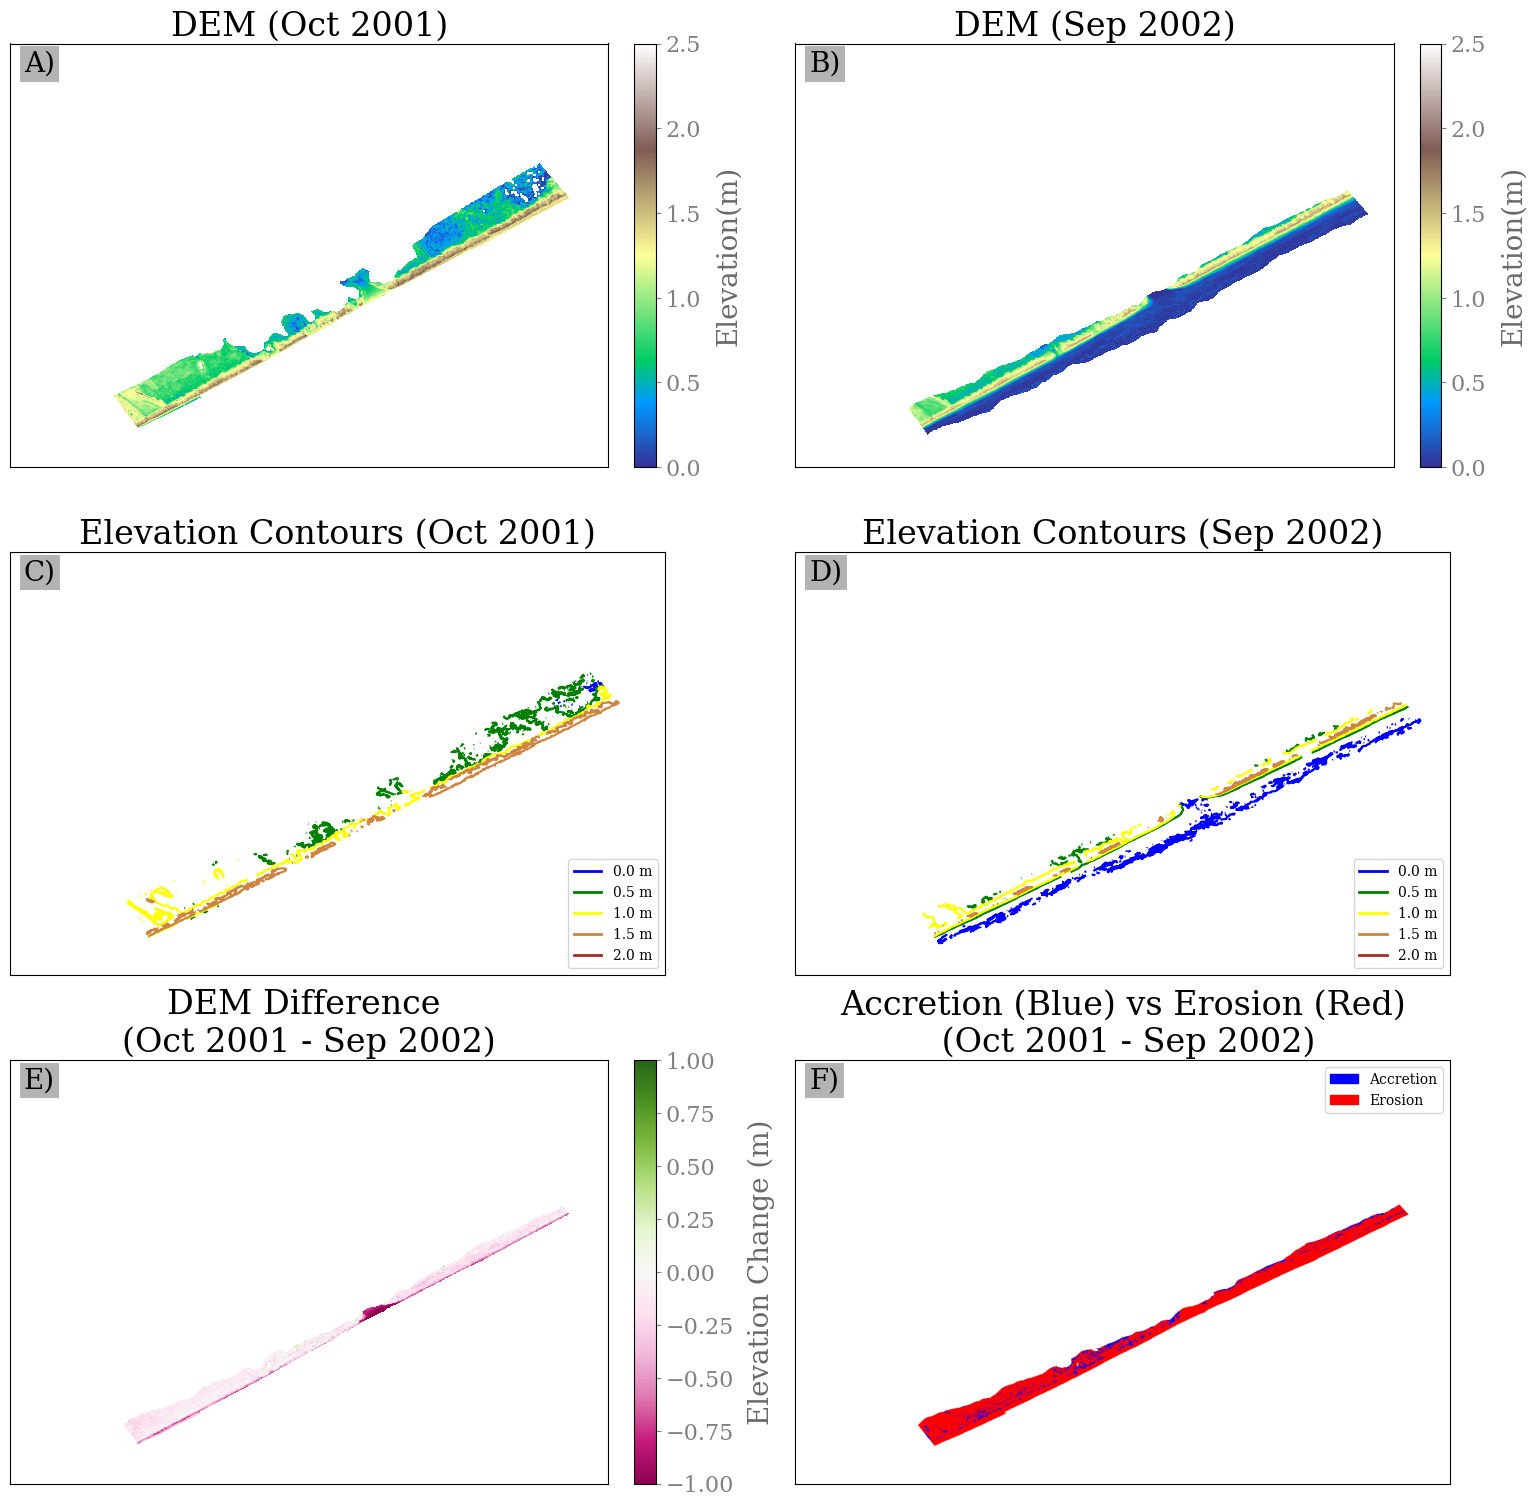

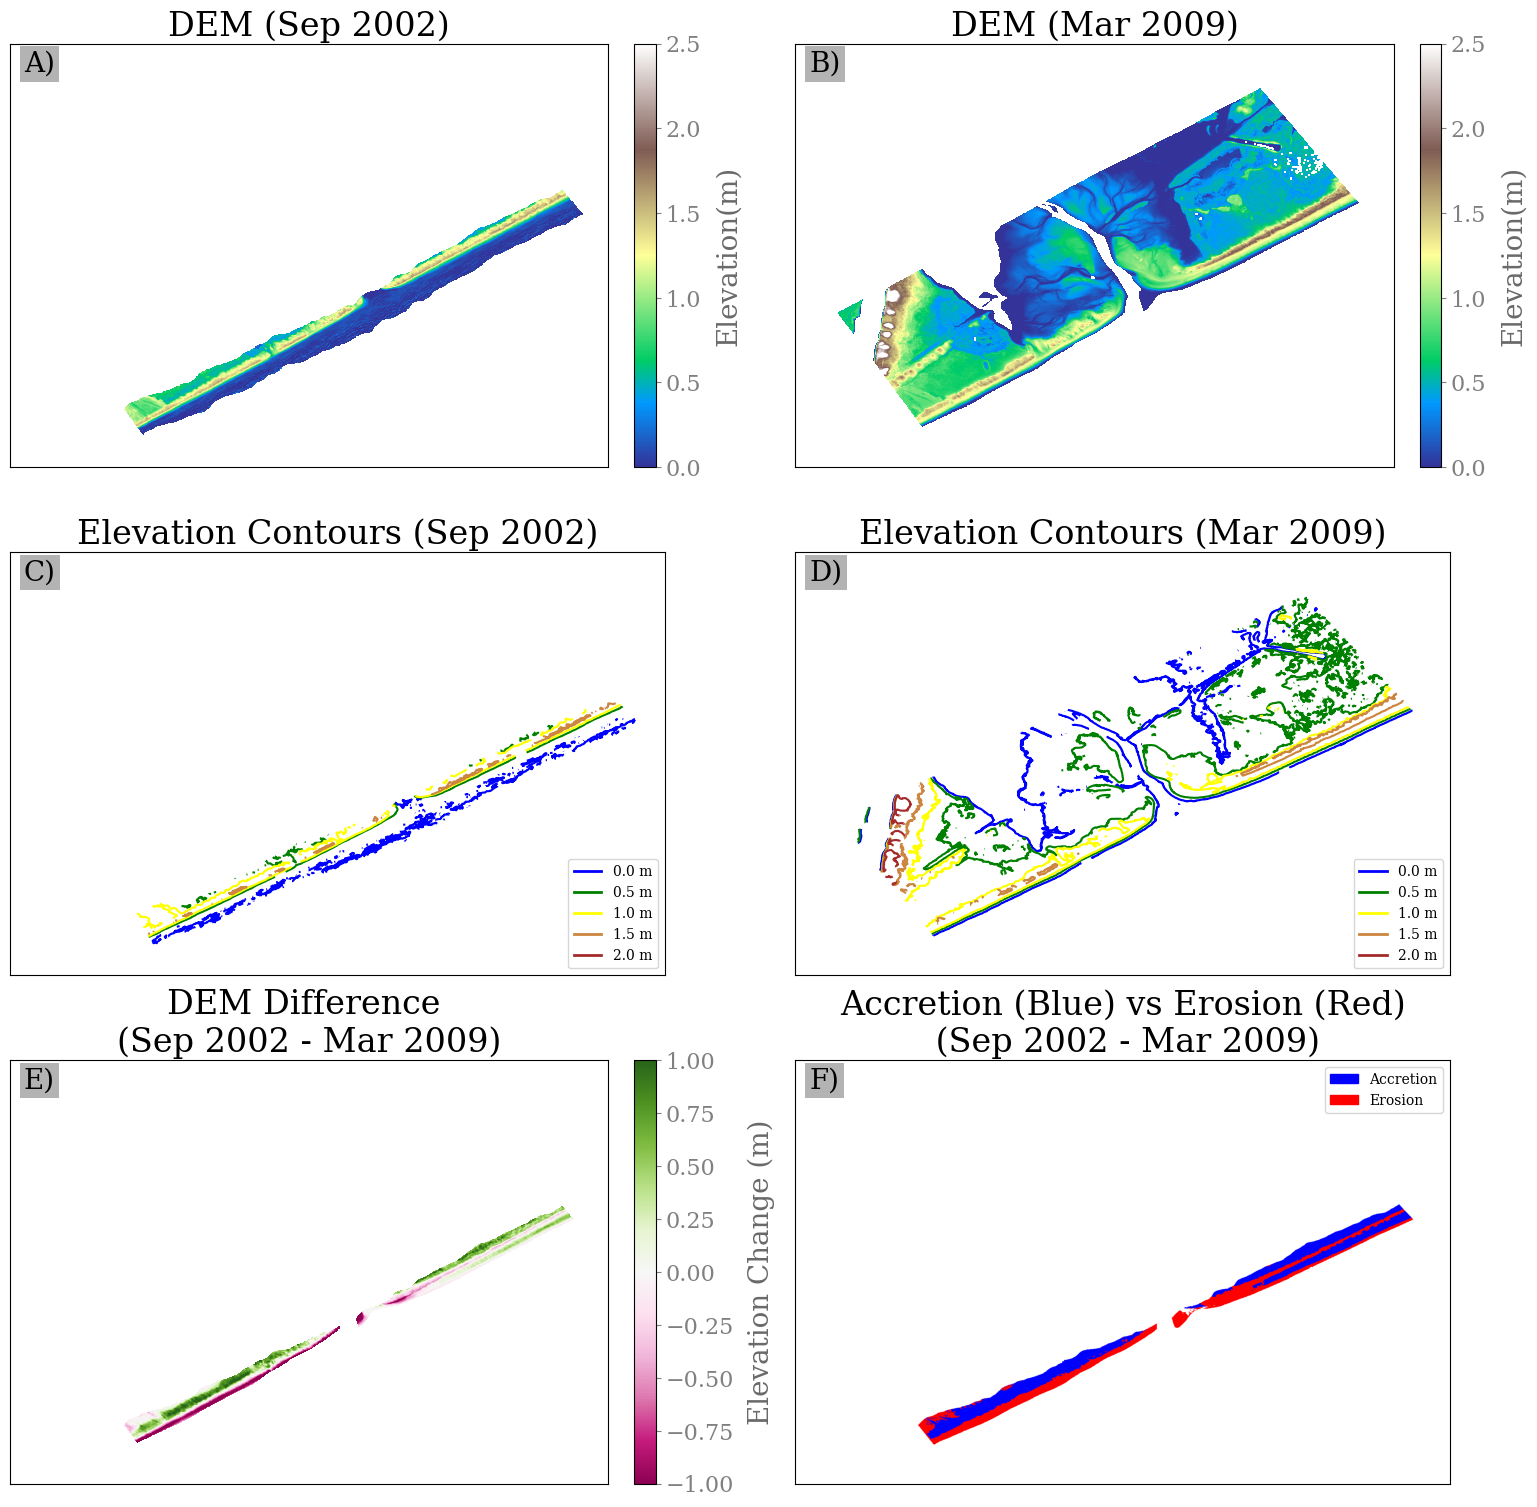

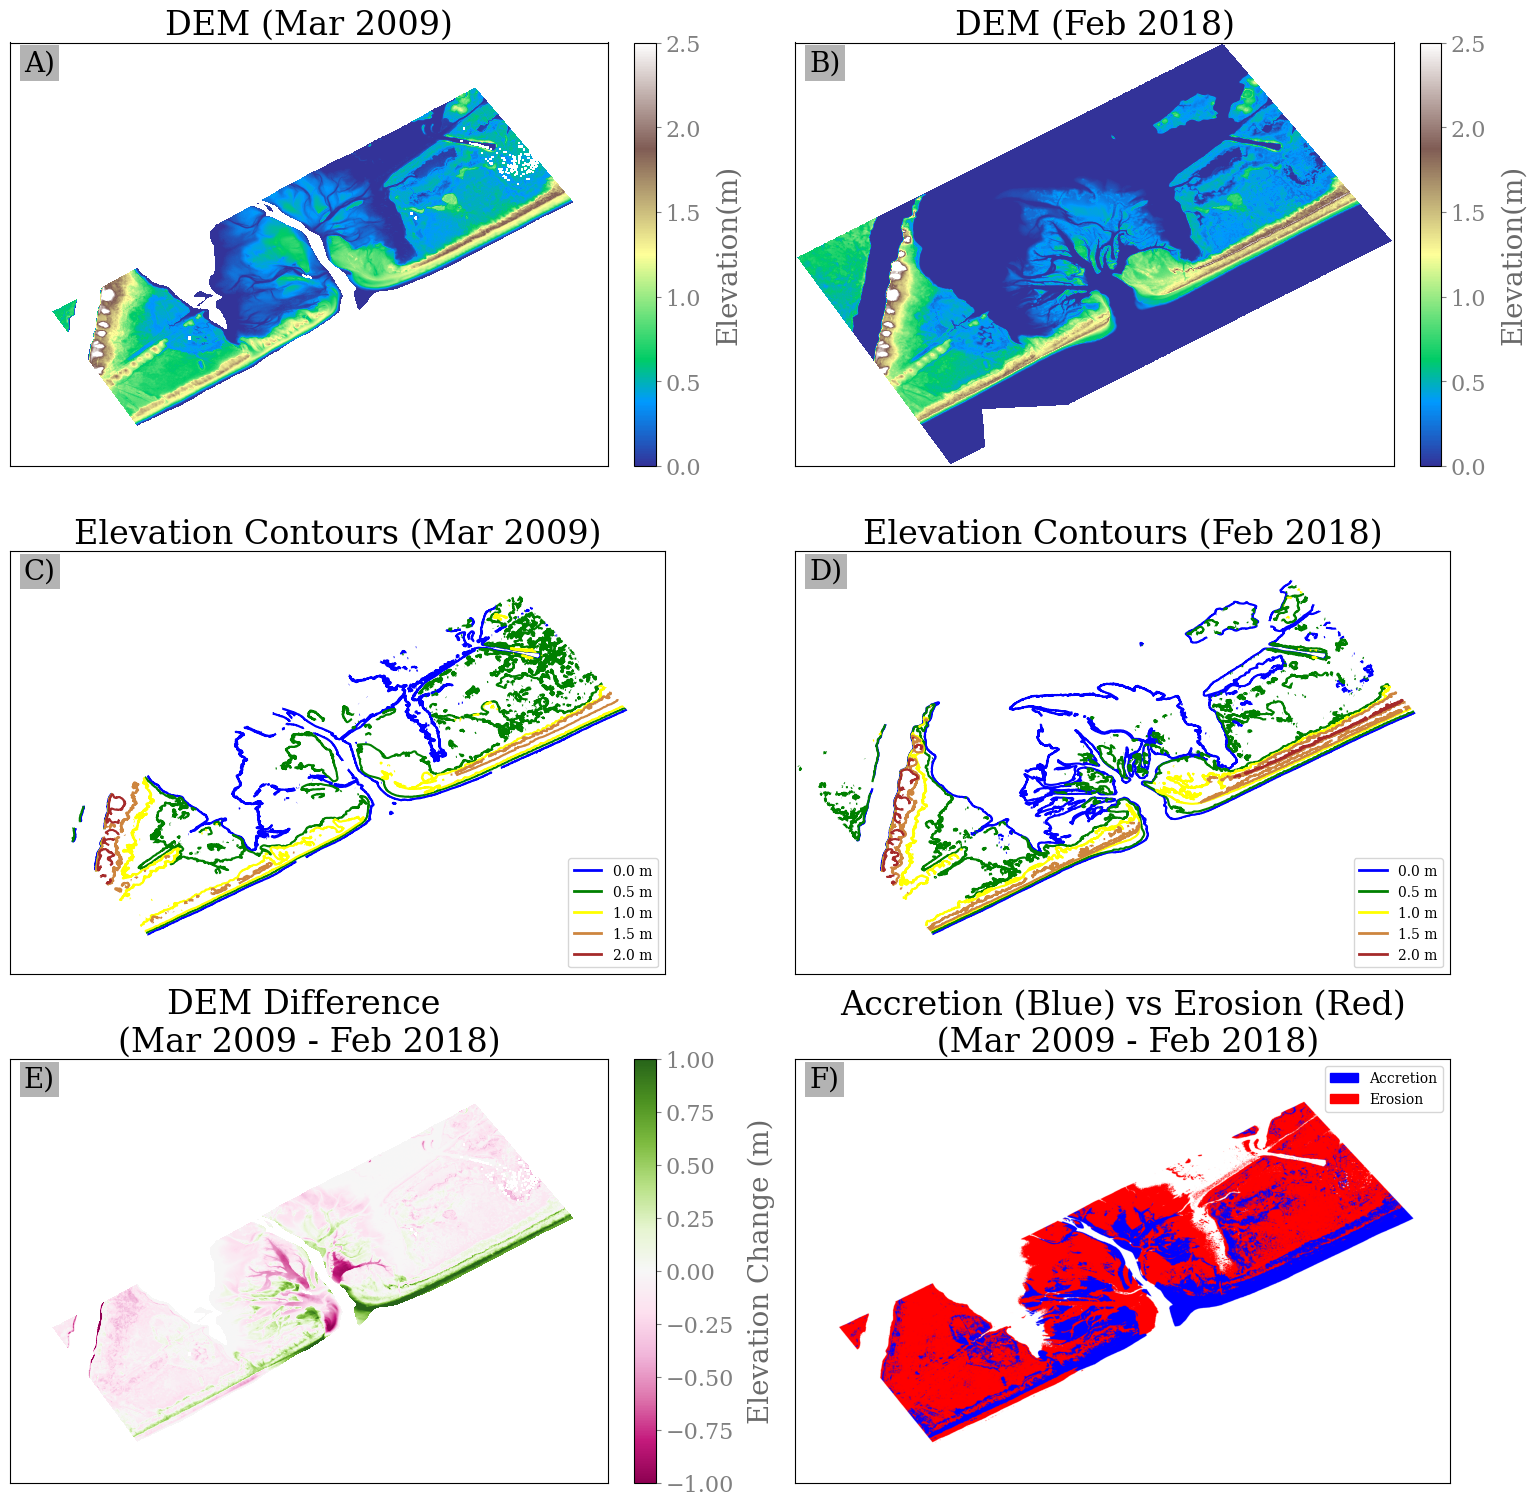

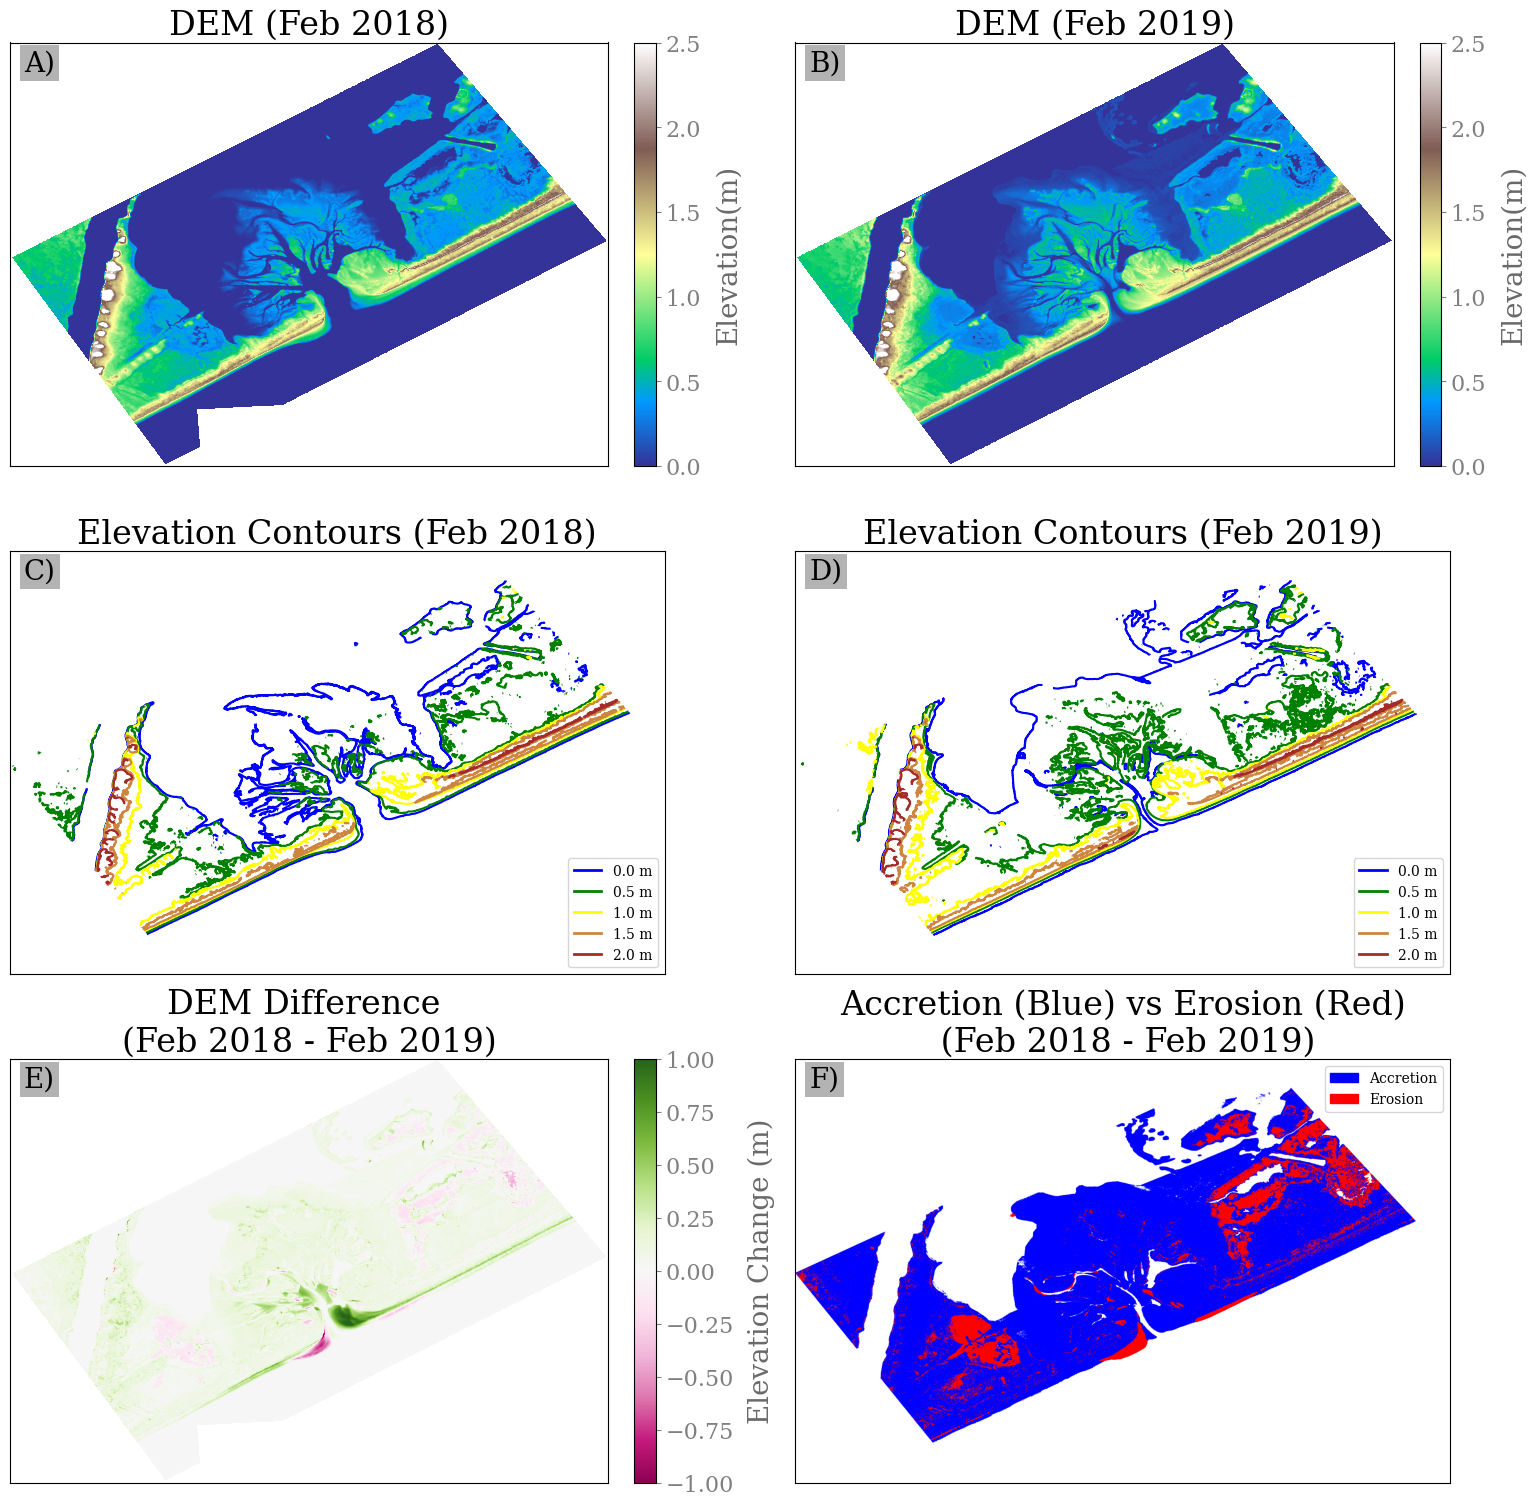

In [12]:
NAVD88toMSL = -0.09
results = []
for rasters_dict in rasters_combination:
    rasters = []
    names = []
    first_array_shape = None
    first_transform = None
    first_meta = None

    for path, name in rasters_dict:
        array, transform, meta = clip_raster(path, bbox_geojson)
        if array is not None:
            # array, transform, meta = rotate_image(
            #     array, transform, meta, **rotation_params
            # )

            if first_array_shape is None:
                first_array_shape = array.shape
                first_transform = transform
                first_meta = meta
            else:
                array = align_raster(
                    array,
                    transform,
                    meta,
                    first_transform,
                    first_meta["crs"],
                    first_array_shape,
                )

            
            rasters.append(array)
            names.append(name)

    # plot_aligned_rasters(rasters, names)

    differences = calculate_difference(rasters[0], rasters[1])
    # print(differences)
    plot_results(rasters, differences, names)
    # results.append((names, differences))